In [15]:
%cd /data/codes/apa/train/

import pandas as pd
import os
from glob import glob
import json
from pandarallel import pandarallel
from tqdm import tqdm
import random
import re

pandarallel.initialize(nb_workers=8, progress_bar=True)

/data/codes/apa/train
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [16]:
json_dir = "/data/audio_data/pronunciation_scoring_result/marking_data/9"
audio_dir = "/data/audio_data/prep_submission_audio/9"

in_csv_path = "/data/audio_data/pronunciation_scoring_result/merged_info/info_question_type-9_19092023_21122023.csv"
out_jsonl_path = "data/metadata/raw-jsonl/train-data-type-9.jsonl"
metadata = pd.read_csv(in_csv_path)
metadata.head(2)

,id,is_deleted,user_id,question_id,question_type,question_content,url,score,fidelity_class,created_at,total_time,word_count
0,5850056,0,92302,224243,9,"I like, uh, prefer to communicate face to face...",https://storage.googleapis.com/materials-eleme...,NaN,NaN,2023-09-27 22:18:11,5.63,12.0
1,5850057,0,92302,224240,9,Yes. I like chatting with my friend a lot.,https://storage.googleapis.com/materials-eleme...,NaN,NaN,2023-09-27 22:18:11,3.86,9.0


In [17]:
import torchaudio

def is_valid_audio(audio_id):
    abs_path = os.path.join(audio_dir, f'{audio_id}.wav')
    if not os.path.exists(abs_path):
        return False
    try:
        wav, sr = torchaudio.load(abs_path)
        if sr != 16000:
            return False
    except:
        return False
    
    return True

is_exist =  metadata.id.parallel_apply(is_valid_audio)
print(metadata.shape)
metadata = metadata[is_exist]
print(metadata.shape)

(101494, 12)
(101485, 12)


In [18]:
def load_lexicon(path):
    vocab = pd.read_csv(path, sep="\t", names=["word", "arpa"])
    lexicon = {}
    for name, group in vocab.groupby("word"):
        lexicon[name] = set(group["arpa"].tolist())

    return lexicon

lexicon_path = "/data/codes/apa/train/exp/dicts/lexicon"
lexicon = load_lexicon(lexicon_path)

In [19]:
decision2color = {
    "correct": 2,
    "warning":1,
    "incorrect":0
}

def norm_text(text):
    text = re.sub(r"[\,\.\!\?\:\;]", " ", text)
    text = re.sub("\s+", " ", text).strip()
    text = text.upper()

    return text

def is_valid_phoneme(phoneme):
    # if phoneme["phoneme_error_arpabet"] != "normal":
    #     trans = phoneme["phoneme_error_arpabet"].split(" - ")[-1]
    #     labels = phoneme["phoneme_error_arpabet"].split(" - ")[0]
    #     if len(labels.split(" ")) >= 2:
    #         return False
        
    #     if len(trans.split(" ")) >= 2:
    #         return False
        
        # if labels in trans:
        #     return False
        
    return True

def is_valid_word(word):
    if norm_text(word["text"]) not in lexicon:
        return False
    
    # if word["trans_arpabet"] not in lexicon[norm_text(word["text"])]:
    #     return False

    if len(word["phonemes"]) != len(word["trans_arpabet"].split()):
        return False

    return True
            
def parse_metadata_data(json_path):
    with open(json_path, "r") as f:
        content = json.load(f)
    id = os.path.basename(json_path).split(".")[0]

    utterances = []

    for raw_utterance in content["utterances"]:
        id = id
        utt_raw_text = raw_utterance["text"]
        utt_uid = raw_utterance["utterance_id"]
        start_time = raw_utterance["start_time"]
        end_time = raw_utterance["end_time"]
        
        if raw_utterance["result"] is None:
            continue

        raw_utterance = raw_utterance["result"]
        
        utt_score = raw_utterance["nativeness_score"]
        intonation_score = raw_utterance["intonation_score"]
        fluency_score = raw_utterance["fluency_score"]

        if intonation_score is None or fluency_score is None:
            continue

        utt_text = []
        utt_arpas = []
        utt_trans = [] 
        utt_phone_scores = []
        utt_decisions = []
        utt_word_scores = []
        utt_word_ids = []
        
        ignore = False
        for word_id, word in enumerate(raw_utterance["words"]):
            word["trans_arpabet"] = word["trans_arpabet"].replace("AH0", "AX")
            
            if is_valid_word(word) == False:
                ignore = True
                break

            for phoneme in word["phonemes"]:
                if is_valid_phoneme(phoneme) == False:
                    ignore = True
                    break

                arpa = phoneme["trans_arpabet"]
                decision = decision2color[phoneme["decision"]]
                score = phoneme["nativeness_score"] if phoneme["nativeness_score"] >= 0 else 0
                tran = phoneme["trans_arpabet"]

                utt_phone_scores.append(score)
                utt_word_ids.append(word_id)
                utt_trans.append(tran)
                utt_decisions.append(decision)

            wrd_score = word["nativeness_score"]
            wrd_text = norm_text(word["text"])
            wrd_arpa = word["trans_arpabet"].split()
            
            utt_text.append(wrd_text)                
            utt_word_scores.append(wrd_score)
            utt_arpas += wrd_arpa
        

        utterance = {
            "id": id,
            "raw_text": utt_raw_text,
            "text": " ".join(utt_text),
            "utt_id": utt_uid,
            "start_time": start_time,
            "end_time": end_time,
            "arpas": utt_arpas,
            "trans": utt_trans,
            "phone_scores": utt_phone_scores,
            "word_scores": utt_word_scores,
            "decisions": utt_decisions,
            "word_ids": utt_word_ids,
            "utterance_score": utt_score,
            "intonation_score": intonation_score,
            "fluency_score": fluency_score
        }
        
        if ignore == False:
            utterances.append(utterance)
    
    return utterances

extracted_data = metadata.id.parallel_apply(lambda x: parse_metadata_data(os.path.join(json_dir, f'{x}.json')))
# extracted_data.head()
# metadata.id.head(100).apply(lambda x: parse_metadata_data(os.path.join(json_dir, f'{x}.json')))

In [20]:
data = extracted_data.explode().reset_index()["id"]
data = pd.DataFrame({"data": data})
print(data.shape)
data.dropna(inplace=True)
data["text"] = data["data"].apply(lambda x: x["text"])
data = data.reset_index()[["data"]]
print(data.shape)
data.head()

(177140, 1)
(141785, 1)


,data
0,"{'id': '5850057', 'raw_text': 'Yes. I like cha..."
1,"{'id': '5850059', 'raw_text': 'Of course I've ..."
2,"{'id': '5850059', 'raw_text': ' So, I sent som..."
3,"{'id': '5850059', 'raw_text': ' And I believe ..."
4,"{'id': '5850063', 'raw_text': 'Absolutely yes...."


<Axes: >

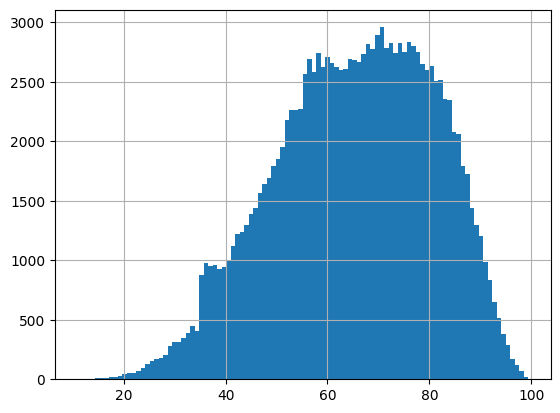

In [21]:
scores = data["data"].apply(lambda x: x["utterance_score"]).to_list()

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

<Axes: >

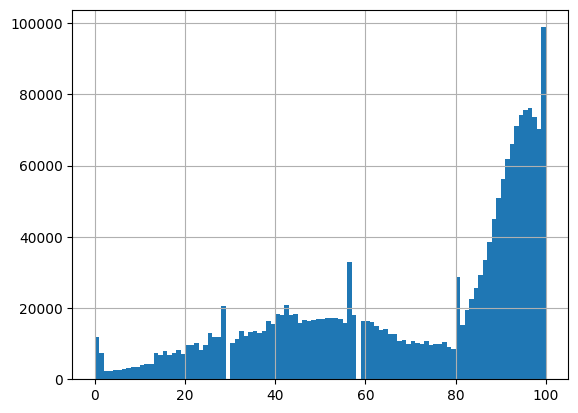

In [22]:
scores = data["data"].apply(lambda x: x["word_scores"]).to_list()
scores = [score for sample in scores for score in sample]

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

(1590338, 1)


<Axes: >

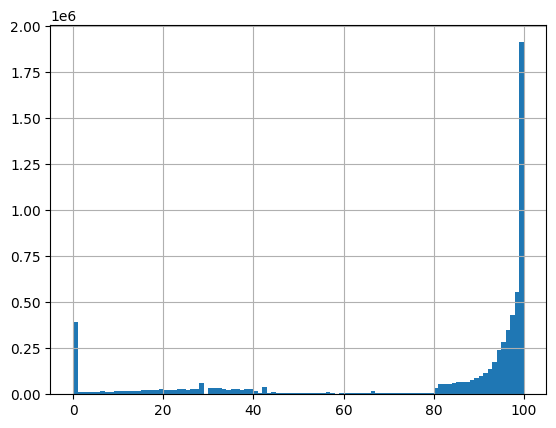

In [23]:
scores = data["data"].apply(lambda x: x["phone_scores"]).to_list()
scores = [score for sample in scores for score in sample]

scores = pd.DataFrame(scores, columns=["score"])
print(scores[scores.score<80].shape)
scores.score.hist(bins=100)

In [24]:
def filter_text(text):
    text = norm_text(text)
    if " AH " in text:
        return False
    if " UH " in text:
        return False
    if " UM " in text:
        return False
    if " UHM " in text:
        return False
    
    if text.startswith("AH ") or text.startswith("UH ") or text.startswith("UM ") or text.startswith("UHM "):
        return False
    
    if text.endswith(" AH") or text.endswith(" UH") or text.endswith(" UM") or text.endswith(" UHM"):
        return False
    
    return True

is_valid = data["data"].apply(lambda x: filter_text(x["raw_text"]))

print(data[is_valid].shape)
print(data[~is_valid].shape)

data = data[is_valid]

(79852, 1)
(61933, 1)


In [25]:
import librosa
import soundfile as sf

def copy_audio(row):
    min_duration = 3.0

    in_audio_dir = "/data/audio_data/prep_submission_audio/9"
    out_audio_dir = "/data/codes/apa/train/data/wav/9"

    id = row["id"]
    utt_id = row["utt_id"]

    in_path = f'{in_audio_dir}/{id}.wav'
    out_path = f'{out_audio_dir}/{id}-{utt_id}.wav'

    start_time = int(row["start_time"] * 16000)
    end_time = int(row["end_time"] * 16000)

    wav, sr = librosa.load(in_path, sr=16000)

    if end_time > wav.shape[0]:
        return False
    
    if wav[start_time:end_time].shape[0] / sr < min_duration:
        return False
    
    assert "audio_data" not in out_path

    sf.write(out_path, data=wav[start_time:end_time], samplerate=sr)

    return True

is_valid = data["data"].parallel_apply(copy_audio)

print(data[is_valid].shape)
print(data[~is_valid].shape)

data = data[is_valid]

(75364, 1)
(4488, 1)


In [26]:
def update_id(row):
    id = row["id"]
    utt_id = row["utt_id"]

    row["id"] = f'{id}-{utt_id}'

    return row

data["data"] = data["data"].parallel_apply(update_id)

In [27]:
length = data["data"].apply(lambda x: len(x["arpas"]))
print(data.shape)
data = data[length < 124]
print(data.shape)

(75364, 1)
(74472, 1)


In [28]:
extracted_data = data
with open(out_jsonl_path, "w", encoding="utf-8") as f:
    for index in tqdm(extracted_data.index):
        sample = extracted_data.loc[index, "data"]
        json_obj = json.dumps(sample)

        f.write(f'{json_obj}\n')

100%|██████████| 74472/74472 [00:01<00:00, 57700.94it/s]
